# Milestone 3: Investigate Project Questions

<hr style="clear:both">

Use this notebook for a quick start to the project. When a question is finished, extract it to multiple function callable from the website

**Project Mentor:** [Aoxiang Fan](https://people.epfl.ch/aoxiang.fan) ([Email](mailto:aoxiang.fan@epfl.ch))
**Authors:** [Luca Carroz](https://people.epfl.ch/emilie.carroz), [David Schroeter](https://people.epfl.ch/david.schroeter), [Xavier Ogay](https://people.epfl.ch/xavier.ogay), [Joris Monnet](https://people.epfl.ch/joris.monnet), [Paulo Ribeiro de Carvalho](https://people.epfl.ch/paulo.ribeirodecarvalho)

<hr style="clear:both">

## Import

In [1]:
# Import needed libraries
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import asyncio

from spotify.SpotifyDataLoader import SpotifyDataLoader
from rapidfuzz import fuzz

# Load autoreload extension
%load_ext autoreload
%autoreload 2

## DataSet
Check that all data sets are already computed, if not please read `README.md` and follow steps for its creation.

In [2]:
folder_path = 'dataset/'
file_names = ['clean_enrich_movies.csv', 'spotify_composers_dataset.csv', 'spotify_dataset.csv']
file_paths = [folder_path + file_name for file_name in file_names]
file_exist = [os.path.exists(file_path) for file_path in file_paths]

if all(file_exist):
    print(f"All files exist and are in the correct directory.")
else:
    print(
        f"At least one file doesn't exist. Please be sure to have the files and to locate them in the right directory (dataset/).")

All files exist and are in the correct directory.


## Load Data

Section to load the enriched and retrieved data.

In [3]:
spotify_composers_dataset = pd.read_pickle('dataset/spotify_composers_dataset.pickle')
clean_enrich_movies = pd.read_pickle('dataset/clean_enrich_movies.pickle')

# display(clean_enrich_movies)

## Question 1

Which are the most frequent music genre appearing in movies ?

In [4]:
# TODO: Discuss about a possible interactive graph. The user can choose the range of box office revenue of movies and see the ranking with genre. GOAL: See if low, middle or high box office revenue have same ranking in music genre or not.
from question_script.question1 import *

min_box_office_revenue = 0
max_box_office_revenue = 1e12

composers_to_movies = create_db_to_link_composers_to_movies(clean_enrich_movies)

movie_music_genre_df = pd.merge(left=spotify_composers_dataset,
                                right=composers_to_movies,
                                left_on='name',
                                right_on='composer_name',
                                how='inner')[['movie_name', 'genres', 'movie_revenue']]

selected_movie_music_genre_df = movie_selection_over_revenue(df=movie_music_genre_df,
                                                             min_revenue=min_box_office_revenue,
                                                             max_revenue=max_box_office_revenue)

genre_distribution_over_movies(selected_movie_music_genre_df).sort_values(by='count', ascending=False)

,genre,count
3,soundtrack,2792
46,orchestral soundtrack,1549
44,classic soundtrack,1384
38,british soundtrack,599
40,french soundtrack,255
...,...,...
344,christian metal,1
343,serbian indie,1
341,brazilian contemporary classical,1
340,nu gaze,1


## Question 2

What is the average composer's age at their :
   - first movie appearance ?
   - biggest box office revenue ?

In [5]:
from question_script.question2 import *


## Question 3

How the top composers' career progress over the years ?

In [6]:
from question_script.question3 import *

movie_renamed = prepare_data_for_q3()

display(movie_renamed.head())
print(movie_renamed.shape)

,release_date,composers,box_office_revenue
0,2009,"[Composer(id=1729, name='James Horner', birthd...",2.782275e+09
1,1997,"[Composer(id=1729, name='James Horner', birthd...",2.185372e+09
2,2012,"[Composer(id=37, name='Alan Silvestri', birthd...",1.511758e+09
3,2011,"[Composer(id=2949, name='Alexandre Desplat', b...",1.328111e+09
4,2013,"[Composer(id=6041, name='Brian Tyler', birthda...",1.215577e+09


(7966, 3)


,release_year,composer,box_office_revenue
0,2009,"Composer(id=1729, name='James Horner', birthda...",2.782275e+09
1,1997,"Composer(id=1729, name='James Horner', birthda...",2.185372e+09
2,2012,"Composer(id=37, name='Alan Silvestri', birthda...",1.511758e+09
3,2011,"Composer(id=2949, name='Alexandre Desplat', bi...",1.328111e+09
4,2013,"Composer(id=6041, name='Brian Tyler', birthday...",1.215577e+09


(9129, 3)


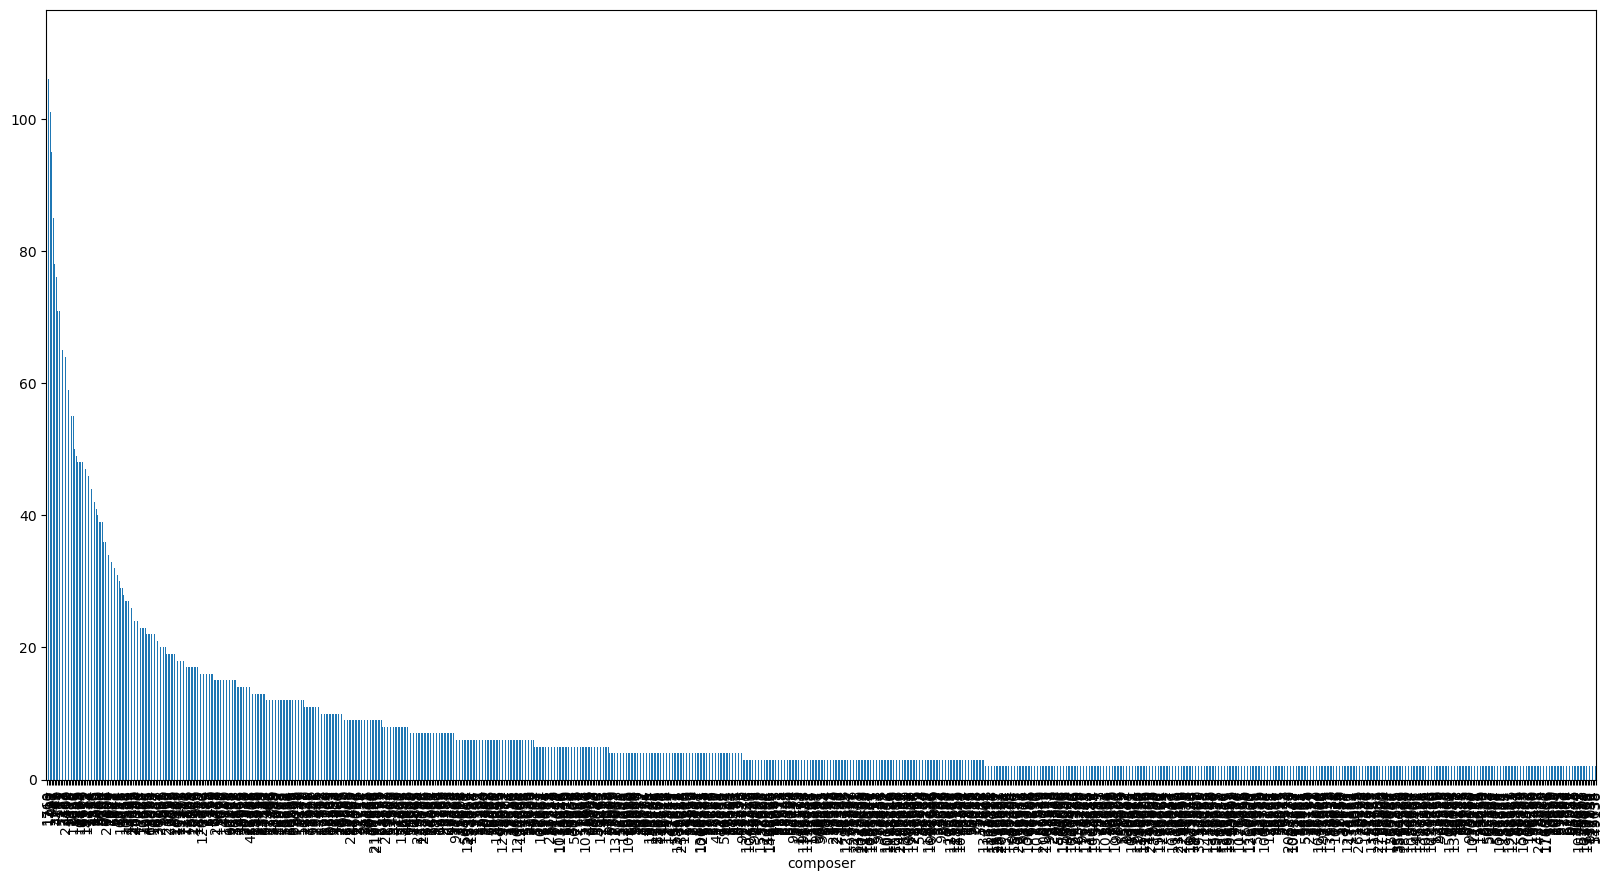

In [7]:
movie_grouped_by_composer = group_by_composer_id(movie_renamed)

# Don't show the composer with only one movie
movie_grouped_by_composer = movie_grouped_by_composer.filter(lambda x: len(x) > 1)

# Plot the number of movies per composer
movie_grouped_by_composer['composer'].value_counts().plot(kind='bar', figsize=(20, 10))
plt.show()

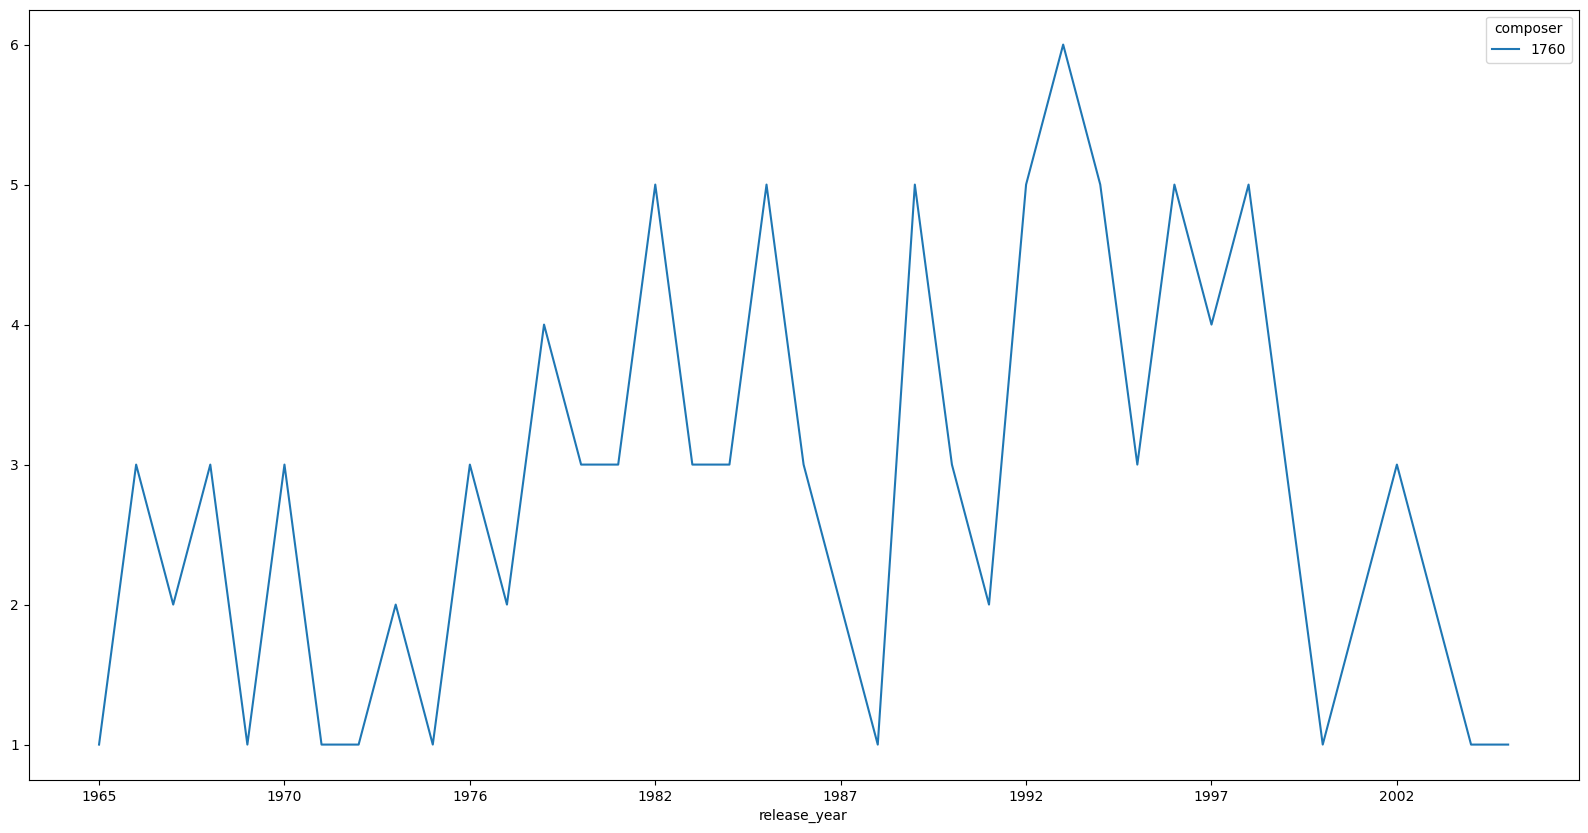

In [8]:
movie_grouped_by_top_composer = filter_by_top_composers(movie_grouped_by_composer, 1)

# Plot the evolution of the number of movies per year for the top 25 composers
movie_grouped_by_composer_and_year = movie_grouped_by_top_composer.groupby(['composer', 'release_year'])
movie_grouped_by_composer_and_year['composer'].value_counts().unstack(0).plot(figsize=(20, 10))
plt.show()

<Axes: xlabel='release_year'>

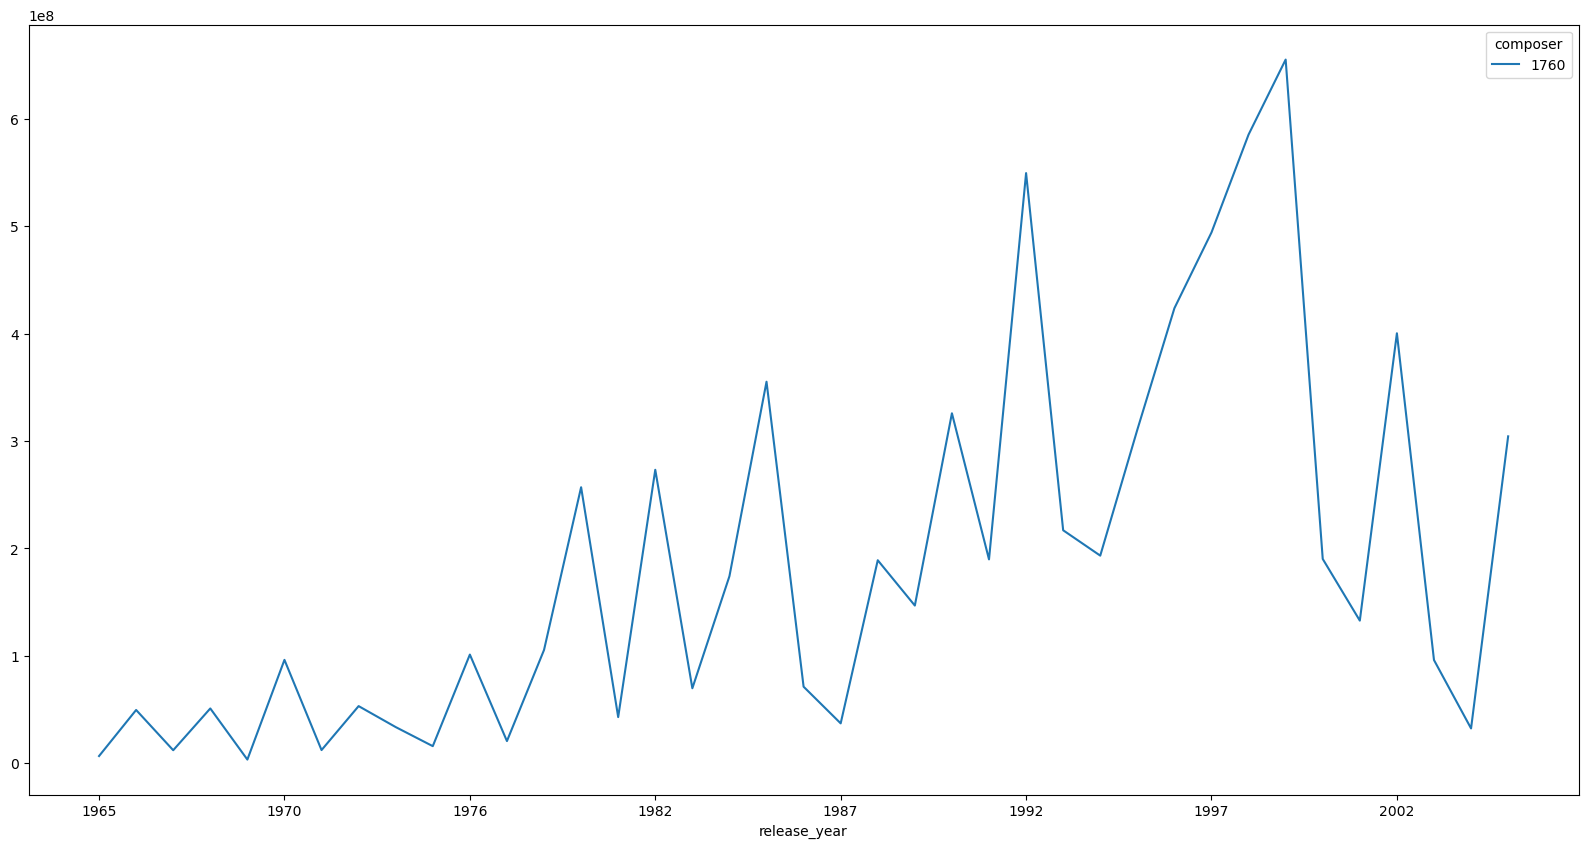

In [9]:
# Plot the evolution of the revenue for the film per year for the top composers
movie_grouped_by_composer_and_year['box_office_revenue'].sum().unstack(0).plot(figsize=(20, 10))

## Question 4

Where do composers come from ?

## Question 5

Does composer's gender matter ?

## Question 6

Does having a personal website correlate with the composers' success ?

## Question 7

Is there a correlation between box office revenue and movie's playlist popularity ?

In [10]:
# Use the already computed dataframe from q.1
box_office_and_composer_popularity = pd.merge(left=spotify_composers_dataset,
                                              right=composers_to_movies,
                                              left_on='name',
                                              right_on='composer_name',
                                              how='inner')[['movie_name', 'movie_revenue','composer_name','release_date', 'popularity']]

box_office_and_composer_popularity.columns

Index(['movie_name', 'movie_revenue', 'composer_name', 'release_date',
       'popularity'],
      dtype='object')

In [11]:
movie_names_and_date = box_office_and_composer_popularity[["movie_name","release_date","movie_revenue","composer_name"]]
columns = movie_names_and_date.columns.values
columns = np.append(columns, "album_id")
movie_albums_df = pd.DataFrame(columns=columns)

#Define keywords to search for soundtrack of movies
POSITIVE_KEYWORD = ["original", "motion", "picture", "soundtrack", "music", "band", "score", "theme", "ost", "ost.", "album", "composed", "conducted"]
NEGATIVE_KEYWORD = ["game", "video", "television", "series", "show", "episode", "season", "episode", "seasons","remastered", "remaster", "live", "bonus"]
NEUTRAL_KEYWORD = ["the", "of", "from", "in", "on", "at", "for", "a", "an", "and", "or", "with", "by", "to", "version", "vol", "vol.", "pt", "pt.", "part", "part.", "ver", "ver.", "&"]

POSITIVE_INFLUENCE = 1.1
NEGATIVE_INFLUENCE = 0.9

BATCH_SIZE = 100

In [12]:

def count_occurence_and_return_diff(movie_name, query_words, keyword_list):
    words = []
    count = 0
    movie_words = movie_name.lower().split()
    for word in keyword_list:
        if word not in movie_words:
            words.append(word)
            if word in query_words:
                count += 1
    return count, words

def score_best_matching_albums(albums_df: pd.DataFrame, date, name, composer):
    score = []
    for j in range(len(albums_df.values)):
        artist_bool = False
        album = albums_df.loc[j]
        
        if composer:
            for artist in album["artists"]:
                if fuzz.ratio(composer, artist["name"]) > 85 or "Various Artists" == artist["name"]:
                    artist_bool = True
                    break
            if not artist_bool:
                continue
            
        if date:    
            if not (str(date) in (str(album["release_date"])) or str(int(date)-1) in (str(album["release_date"])) or str(int(date)+1) in (str(album["release_date"]))):
                continue
        
        movie_name = name.lower()
        query_name = album["name"].lower()
        if not("(" in movie_name or ")" in movie_name):
            query_name = query_name.replace("(", "")
            query_name = query_name.replace(")", "")
        
        query_words = query_name.split()
        
        
        pos_count, positive_words  = count_occurence_and_return_diff(movie_name, query_words, POSITIVE_KEYWORD)
        neg_count, negative_words  = count_occurence_and_return_diff(movie_name, query_words, NEGATIVE_KEYWORD)
        neu_count, neutral_words   = count_occurence_and_return_diff(movie_name, query_words, NEUTRAL_KEYWORD)

        to_remove = positive_words + negative_words + neutral_words
        cleaned_query  = [word for word in query_words if word.lower() not in to_remove]
        result = ' '.join(cleaned_query)

        if not (max(movie_name.split(), key=len) in result):
            continue
        
        modifiers = POSITIVE_INFLUENCE**pos_count * NEGATIVE_INFLUENCE**neg_count
        score += [(j, modifiers*fuzz.ratio(movie_name, result))]
    return score       

In [13]:
async with SpotifyDataLoader() as spotify:
    count = 0
    for i in range(0, 250, BATCH_SIZE):
        #Get all the albums for the movies in the batch
        print("_____________________________________________%i_____________________________________________" %i)
        batch = movie_names_and_date.loc[i:i + BATCH_SIZE]
        date = list(batch.release_date)
        names = list(batch.movie_name)
        composer = list(batch.composer_name)
        results = await spotify.search_albums_by_name(names)
        for j, albums in enumerate(results):
            albums_df = pd.DataFrame(albums)
            scores = score_best_matching_albums(albums_df, date[j], names[j], composer[j])
            if len(scores) > 0:
                best_score = max(scores, key=lambda x: x[1])
                print(names[j], " - ", albums_df.loc[best_score[0]]["name"], " - ", best_score[1], "\n")
                row= movie_names_and_date.loc[i+j].copy()
                row["album_id"] = albums_df.loc[best_score[0]]["id"]
                movie_albums_df.loc[count] = row 
                count += 1
        
display(movie_albums_df)

_____________________________________________0_____________________________________________
Jaws 3-D  -  Jaws 3-D (Original Motion Picture Soundtrack)  -  146.41000000000005 

Jonathan Livingston Seagull  -  Jonathan Livingston Seagull  -  100.0 

Invictus  -  Invictus (Original Motion Picture Soundtrack)  -  146.41000000000005 

Dr. T & the Women  -  Dr. T & The Women (Original Motion Picture Soundtrack)  -  146.41000000000005 

Get Rich or Die Tryin'  -  Get Rich Or Die Tryin'- The Original Motion Picture Soundtrack  -  143.15644444444447 

In Cold Blood  -  In Cold Blood (Original Soundtrack Recording)  -  87.38888888888889 

The Pawnbroker  -  The Pawnbroker  -  100.0 

Get Rich or Die Tryin'  -  Get Rich Or Die Tryin'- The Original Motion Picture Soundtrack  -  143.15644444444447 

In Cold Blood  -  In Cold Blood (Original Soundtrack Recording)  -  87.38888888888889 

The Pawnbroker  -  The Pawnbroker  -  100.0 
The Haunting in Connecticut  -  The Haunting in Connecticut (Original

,movie_name,release_date,movie_revenue,composer_name,album_id
0,Jaws 3-D,1983,87987055.0,Alan Parker,6BndxUUvNgpFD2uOJO61bJ
1,Jonathan Livingston Seagull,1973,1600000.0,Neil Diamond,3WpPBSIAlElw91HMtjOOh9
2,Invictus,2009,122233971.0,Michael Stevens,08n7ViKJPai5AJcrzHRBOw
3,Dr. T & the Women,2000,22844291.0,Lyle Lovett,1BTRq8qDqa6prb1hgnd0NP
4,Get Rich or Die Tryin',2005,46442528.0,Quincy Jones,5D2CHiTlb8MXWJsZWXjkZf
5,In Cold Blood,1967,13000000.0,Quincy Jones,7gAax1aiv5glXulIHYoVPo
6,The Pawnbroker,1965,3000000.0,Quincy Jones,2Jdv79qcL3lMYKRfTG7aBL
7,Get Rich or Die Tryin',2005,46442528.0,Quincy Jones,5D2CHiTlb8MXWJsZWXjkZf
8,In Cold Blood,1967,13000000.0,Quincy Jones,7gAax1aiv5glXulIHYoVPo
9,The Pawnbroker,1965,3000000.0,Quincy Jones,2Jdv79qcL3lMYKRfTG7aBL


In [14]:
async with SpotifyDataLoader() as spotify:
    for i in range(0, len(movie_albums_df), BATCH_SIZE):
        #Get all the tracks ids of the albums in the batch
        batch = list(movie_albums_df.loc[i:i + BATCH_SIZE]["album_id"])
        results = await spotify.get_albums_tracks_async(batch)
        movie_albums_df.loc[i:i + BATCH_SIZE, "track_ids"] = np.array(results, dtype=object)
display(movie_albums_df)        

,movie_name,release_date,movie_revenue,composer_name,album_id,track_ids
0,Jaws 3-D,1983,87987055.0,Alan Parker,6BndxUUvNgpFD2uOJO61bJ,"[17BdpgCg7CIUiOdSOjn3Mw, 2L0CPBGQ0ew5YLzfP1nFF..."
1,Jonathan Livingston Seagull,1973,1600000.0,Neil Diamond,3WpPBSIAlElw91HMtjOOh9,"[675ABhVqTwspFQ7s8bZqv1, 79nuIMSS0eg1SQpXQv4Qn..."
2,Invictus,2009,122233971.0,Michael Stevens,08n7ViKJPai5AJcrzHRBOw,"[4mmvcMzMiMc883gUh2NG1A, 5RYbZrTSFecmltMHGqjTS..."
3,Dr. T & the Women,2000,22844291.0,Lyle Lovett,1BTRq8qDqa6prb1hgnd0NP,"[7thQwacCXrqpKBMIQKN6vj, 2PavDN1bGED898Y7juqsO..."
4,Get Rich or Die Tryin',2005,46442528.0,Quincy Jones,5D2CHiTlb8MXWJsZWXjkZf,"[7t67S1XHT4jU0GCkruG34R, 5aWlEuY1dSo4uVJgHz5re..."
5,In Cold Blood,1967,13000000.0,Quincy Jones,7gAax1aiv5glXulIHYoVPo,"[6nN9AKEU7P3nw1Is1ld3lc, 1xCPysyZOkMJaE29J1qTH..."
6,The Pawnbroker,1965,3000000.0,Quincy Jones,2Jdv79qcL3lMYKRfTG7aBL,"[0DBfR7YjYtVUK8ypXXjcYZ, 2hH0IJRExWzCezCXdfFX1..."
7,Get Rich or Die Tryin',2005,46442528.0,Quincy Jones,5D2CHiTlb8MXWJsZWXjkZf,"[7t67S1XHT4jU0GCkruG34R, 5aWlEuY1dSo4uVJgHz5re..."
8,In Cold Blood,1967,13000000.0,Quincy Jones,7gAax1aiv5glXulIHYoVPo,"[6nN9AKEU7P3nw1Is1ld3lc, 1xCPysyZOkMJaE29J1qTH..."
9,The Pawnbroker,1965,3000000.0,Quincy Jones,2Jdv79qcL3lMYKRfTG7aBL,"[0DBfR7YjYtVUK8ypXXjcYZ, 2hH0IJRExWzCezCXdfFX1..."


In [20]:
async with SpotifyDataLoader() as spotify:
    for i, ids in enumerate(movie_albums_df["track_ids"]):
        #Get the track from the track ids
        tracks, genres = await spotify.get_tracks_from_tracks_ids(ids, genre=True)
        zipped = zip(tracks, genres)
        musics = [spotify.get_music_from_track(track, genre) for (track, genre) in zipped]
        display(pd.DataFrame(musics))

        #movie_albums_df.loc[i, "tracks"] = np.array(results, dtype=object)

,id,name,genre,composer_id,popularity
0,17BdpgCg7CIUiOdSOjn3Mw,"Jaws 3-D Main Title - From The ""Jaws 3D"" Sound...",[library music],0ZpOIHGVsM7vMZqPt4i214,7
1,2L0CPBGQ0ew5YLzfP1nFFc,"Kay And Mike's Love Theme - From The ""Jaws 3D""...",[library music],0ZpOIHGVsM7vMZqPt4i214,6
2,3DEmoTEpqNO0WytKVGBSFk,"Panic At Seaworld - From The ""Jaws 3D"" Soundtrack",[library music],0ZpOIHGVsM7vMZqPt4i214,3
3,3BKemzCHBlYd7k4MklWz0T,Underwater Kingdom And Shark Chase - From The ...,[library music],0ZpOIHGVsM7vMZqPt4i214,3
4,6rzOkNYXS5OlqReMwIYL6T,"Shark Chase And Dolphin Rescue - From The ""Jaw...",[library music],0ZpOIHGVsM7vMZqPt4i214,3
5,3xVOBlw3tBMKjsCcFbYMwO,"Saved By The Dolphins - From The ""Jaws 3D"" Sou...",[library music],0ZpOIHGVsM7vMZqPt4i214,3
6,7iQAUXinKuCuNceonAVTLd,"The Shark's Gonna Hit Us! - From The ""Jaws 3D""...",[library music],0ZpOIHGVsM7vMZqPt4i214,6
7,2vYboHGwJkunwH3LmiX09c,"Overman's Last Dive - From The ""Jaws 3D"" Sound...",[library music],0ZpOIHGVsM7vMZqPt4i214,2
8,3ymGLCeq219Wyj599IjPuC,"Philip's Demise - From The ""Jaws 3D"" Soundtrack",[library music],0ZpOIHGVsM7vMZqPt4i214,3
9,3JTr9ZGGZNTj1hk840zT9V,"Night Capture - From The ""Jaws 3D"" Soundtrack",[library music],0ZpOIHGVsM7vMZqPt4i214,2


,id,name,genre,composer_id,popularity
0,675ABhVqTwspFQ7s8bZqv1,Prologue,"[adult standards, brill building pop, folk roc...",7mEIug7XUlQHikrFxjTWes,34
1,79nuIMSS0eg1SQpXQv4Qn0,Be - Introduction Of Jonathan,"[adult standards, brill building pop, folk roc...",7mEIug7XUlQHikrFxjTWes,43
2,2lo3lzKqnCreKCjE1Drka8,Flight Of The Gull,"[adult standards, brill building pop, folk roc...",7mEIug7XUlQHikrFxjTWes,36
3,2OscEjH4wPhSzzsb56edyU,Dear Father - Instrumental,"[adult standards, brill building pop, folk roc...",7mEIug7XUlQHikrFxjTWes,37
4,4wtnn2ySNQSeTVwTr98ZYN,Skybird - Instrumental,"[adult standards, brill building pop, folk roc...",7mEIug7XUlQHikrFxjTWes,36
5,0CZVTal1BQSQ0jiZCdsO7k,Lonely Looking Sky,"[adult standards, brill building pop, folk roc...",7mEIug7XUlQHikrFxjTWes,44
6,1byLYKIUXGmHl4FHsbBAGu,The Odyssey - Be / Lonely Looking Sky / Dear F...,"[adult standards, brill building pop, folk roc...",7mEIug7XUlQHikrFxjTWes,32
7,5761RtNUutTrT4geqNThkr,Anthem,"[adult standards, brill building pop, folk roc...",7mEIug7XUlQHikrFxjTWes,38
8,4ntYfipNJharvEMGTIhx90,Be - Jonathan Returns,"[adult standards, brill building pop, folk roc...",7mEIug7XUlQHikrFxjTWes,32
9,3zbnjfU5pMCl9t1kEC9Ted,Skybird,"[adult standards, brill building pop, folk roc...",7mEIug7XUlQHikrFxjTWes,44


,id,name,genre,composer_id,popularity
0,4mmvcMzMiMc883gUh2NG1A,"9,000 Days",[jazz double bass],6u5sKtTae4k0XbjRpDRrcM,19
1,5RYbZrTSFecmltMHGqjTS8,Invictus Theme,[jazz double bass],2QUGNfaOw1iDPrXbECsd4I,21
2,3XltDE4eIR62HKEobYvuA9,Colorblind,[jazz double bass],6u5sKtTae4k0XbjRpDRrcM,16
3,00VhDM206ypXRMdwSM59PF,Siyalinda,[jazz double bass],2QUGNfaOw1iDPrXbECsd4I,9
4,6kQjRDCo1yjpYgnHO3rSCg,World In Union '95,[jazz double bass],6u5sKtTae4k0XbjRpDRrcM,25
5,5tqLoAwrnD4WGQvpb3LCkY,Madiba's Theme,[jazz double bass],2QUGNfaOw1iDPrXbECsd4I,17
6,3Pnp2SNHr0SpNwLW5XsbLm,Hamba Nathi,[jazz double bass],6u5sKtTae4k0XbjRpDRrcM,16
7,2Zm2uOU4CNwpXy6suy4IUj,Thanda,[jazz double bass],2QUGNfaOw1iDPrXbECsd4I,10


,id,name,genre,composer_id,popularity
0,7thQwacCXrqpKBMIQKN6vj,Dr. T's Theme,"[classic texas country, country rock, folk, he...",0zlJDQgqnr9AocrH9gs1Es,3
1,2PavDN1bGED898Y7juqsOR,Opening Credits,"[classic texas country, country rock, folk, he...",0zlJDQgqnr9AocrH9gs1Es,1
2,3MgX3Xl4NVAPTrNoIPqgv8,Mall Women,"[classic texas country, country rock, folk, he...",0zlJDQgqnr9AocrH9gs1Es,2
3,4GOlcTLqycrj80JtO3QMyp,The Fountain,"[classic texas country, country rock, folk, he...",0zlJDQgqnr9AocrH9gs1Es,1
4,6C31aSwwBGKeiPRit6jyi0,The Bree Shuffle,"[classic texas country, country rock, folk, he...",0zlJDQgqnr9AocrH9gs1Es,1
5,6EbpCH49ba90CqjDBjRdsk,Golf Cart Love,"[classic texas country, country rock, folk, he...",0zlJDQgqnr9AocrH9gs1Es,1
6,67u1LSyZjWAVSYMAiTkj6i,The Bridal Shower,"[classic texas country, country rock, folk, he...",0zlJDQgqnr9AocrH9gs1Es,1
7,02VOtYcfnY0JZZGDNPUjm9,You've Been So Good Up To Now,"[classic texas country, country rock, folk, he...",0zlJDQgqnr9AocrH9gs1Es,2
8,5sAVTA2W4xMm24oxJOxWKJ,She's Already Made Up Her Mind,"[classic texas country, country rock, folk, he...",0zlJDQgqnr9AocrH9gs1Es,2
9,53cDJP7yipEpEKnF4mjEZ4,Lady Of The Lake,"[classic texas country, country rock, folk, he...",0zlJDQgqnr9AocrH9gs1Es,1


,id,name,genre,composer_id,popularity
0,7t67S1XHT4jU0GCkruG34R,Hustler's Ambition,"[east coast hip hop, gangster rap, hip hop, po...",3q7HBObVc0L8jNeTe5Gofh,64
1,5aWlEuY1dSo4uVJgHz5reX,What If,"[east coast hip hop, gangster rap, hip hop, po...",3q7HBObVc0L8jNeTe5Gofh,41
2,6iU8jDJTT0RSlRoP5iAP7Z,Things Change,[west coast rap],2hS7xiUEsGIzQDFD7aZUYO,40
3,2PjixJLQjUxp9TzvCqJMGx,You Already Know,"[east coast hip hop, gangster rap, hip hop, po...",3vDUJHQtqT3jFRZ2ECXDTi,44
4,10CTmUY2JXjel9amI7VgQs,When Death Becomes U,"[detroit hip hop, gangster rap, hardcore hip h...",1BH45DVSTeGBvcYXNCd67g,42
5,23or0MrIRJCxCCqjK2Q9Od,Have A Party,"[detroit hip hop, gangster rap, hardcore hip h...",6O2zJ0tId7g07yzHtX0yap,38
6,4fNIUqkM1oQGRqKekqCPAY,We Both Think Alike,"[east coast hip hop, gangster rap, hip hop, po...",3q7HBObVc0L8jNeTe5Gofh,36
7,4wUCojsBsqeS7RTrpFKWxb,Don't Need No Help,"[crunk, dirty south rap, nashville hip hop]",4pr7J7wzgObkE3DD3Izi7q,36
8,0sTSaoK8Jzl3nbyXKQMuV8,Get Low,"[east coast hip hop, hardcore hip hop]",3vDUJHQtqT3jFRZ2ECXDTi,44
9,7rGkjh2xfOaROenGkja0Cf,Fake Love,"[east coast hip hop, gangster rap, hip hop, po...",50UMTib697JJ44le8DO2Va,38


,id,name,genre,composer_id,popularity
0,6nN9AKEU7P3nw1Is1ld3lc,In Cold Blood,[soul jazz],3rxIQc9kWT6Ueg4BhnOwRK,7
1,1xCPysyZOkMJaE29J1qTH2,Clutter Family Theme,[soul jazz],3rxIQc9kWT6Ueg4BhnOwRK,3
2,3vw4wNGhLLR1850T9sR7jy,Hangin' Paper,[soul jazz],3rxIQc9kWT6Ueg4BhnOwRK,5
3,2hJoW77oSVWrCrGBG7sq7j,Down Clutter's Lane,[soul jazz],3rxIQc9kWT6Ueg4BhnOwRK,3
4,2ngBXFFOjRggectoMY5Fte,Seduction,[soul jazz],3rxIQc9kWT6Ueg4BhnOwRK,3
5,4scm2pIPcPuQ4DWeD6R56Y,Perry's Theme,[soul jazz],3rxIQc9kWT6Ueg4BhnOwRK,4
6,1VL89vD4EsqLOwRcFapWue,Lonely Bottles,[soul jazz],3rxIQc9kWT6Ueg4BhnOwRK,5
7,0rj5ZmtgoRS00UEwDXqFOK,No Witnesses,[soul jazz],3rxIQc9kWT6Ueg4BhnOwRK,2
8,5bYDZKmS1fuFSPs6FLDj7J,I'll Have To Kill You,[soul jazz],3rxIQc9kWT6Ueg4BhnOwRK,2
9,5omFenfqQsBHv2zQ9vK8sn,Nina,[soul jazz],3rxIQc9kWT6Ueg4BhnOwRK,3


,id,name,genre,composer_id,popularity
0,0DBfR7YjYtVUK8ypXXjcYZ,Theme From The Pawnbroker,[soul jazz],3rxIQc9kWT6Ueg4BhnOwRK,5
1,2hH0IJRExWzCezCXdfFX1g,Main Title: The Pawnbroker,[soul jazz],3rxIQc9kWT6Ueg4BhnOwRK,8
2,5CvTpefwhhK11d1AV3WHaf,Harlem Drive,[soul jazz],3rxIQc9kWT6Ueg4BhnOwRK,24
3,5XhqvYCaJn0KNOEd1ekBhQ,The Naked Truth,[soul jazz],3rxIQc9kWT6Ueg4BhnOwRK,24
4,1cLX1oSz0miuHuQr9dXsvV,Otez's Night Off,[soul jazz],3rxIQc9kWT6Ueg4BhnOwRK,6
5,0x8RXgnNoQIz8dOZD2sZyz,Theme From The Pawnbroker - Instrumental,[soul jazz],3rxIQc9kWT6Ueg4BhnOwRK,7
6,6MuITHJIYUm7zJFNzZQA0f,"How Come, You People",[soul jazz],3rxIQc9kWT6Ueg4BhnOwRK,1
7,6WCn7efImNb0YqKuct8diL,Rack 'Em Up,[space age pop],3GR38LTiPd7t2yXyRrQvAP,13
8,4kvS4l274Da8vUPWB0MNIA,Death Scene,[soul jazz],3rxIQc9kWT6Ueg4BhnOwRK,6
9,0nnXjqaNnGpMYbx0K5htBp,End Title,[soul jazz],3rxIQc9kWT6Ueg4BhnOwRK,6


,id,name,genre,composer_id,popularity
0,7t67S1XHT4jU0GCkruG34R,Hustler's Ambition,"[east coast hip hop, gangster rap, hip hop, po...",3q7HBObVc0L8jNeTe5Gofh,64
1,5aWlEuY1dSo4uVJgHz5reX,What If,"[east coast hip hop, gangster rap, hip hop, po...",3q7HBObVc0L8jNeTe5Gofh,41
2,6iU8jDJTT0RSlRoP5iAP7Z,Things Change,[west coast rap],2hS7xiUEsGIzQDFD7aZUYO,40
3,2PjixJLQjUxp9TzvCqJMGx,You Already Know,"[east coast hip hop, gangster rap, hip hop, po...",3vDUJHQtqT3jFRZ2ECXDTi,44
4,10CTmUY2JXjel9amI7VgQs,When Death Becomes U,"[detroit hip hop, gangster rap, hardcore hip h...",1BH45DVSTeGBvcYXNCd67g,42
5,23or0MrIRJCxCCqjK2Q9Od,Have A Party,"[detroit hip hop, gangster rap, hardcore hip h...",6O2zJ0tId7g07yzHtX0yap,38
6,4fNIUqkM1oQGRqKekqCPAY,We Both Think Alike,"[east coast hip hop, gangster rap, hip hop, po...",3q7HBObVc0L8jNeTe5Gofh,36
7,4wUCojsBsqeS7RTrpFKWxb,Don't Need No Help,"[crunk, dirty south rap, nashville hip hop]",4pr7J7wzgObkE3DD3Izi7q,36
8,0sTSaoK8Jzl3nbyXKQMuV8,Get Low,"[east coast hip hop, hardcore hip hop]",3vDUJHQtqT3jFRZ2ECXDTi,44
9,7rGkjh2xfOaROenGkja0Cf,Fake Love,"[east coast hip hop, gangster rap, hip hop, po...",50UMTib697JJ44le8DO2Va,38


Error while performing request: 429, message='Too Many Requests', url=URL('https://api.spotify.com/v1/tracks/6nN9AKEU7P3nw1Is1ld3lc')
Spotify API threshold reached:
	Sleeping for 30 seconds!
Error while performing request: 429, message='Too Many Requests', url=URL('https://api.spotify.com/v1/tracks/1xCPysyZOkMJaE29J1qTH2')
Error while performing request: 429, message='Too Many Requests', url=URL('https://api.spotify.com/v1/tracks/1VL89vD4EsqLOwRcFapWue')
Error while performing request: 429, message='Too Many Requests', url=URL('https://api.spotify.com/v1/tracks/2ngBXFFOjRggectoMY5Fte')
Error while performing request: 429, message='Too Many Requests', url=URL('https://api.spotify.com/v1/tracks/6qkcWFQbP8XoZMXvrhYZ4M')


,id,name,genre,composer_id,popularity
0,6nN9AKEU7P3nw1Is1ld3lc,In Cold Blood,[soul jazz],3rxIQc9kWT6Ueg4BhnOwRK,7
1,1xCPysyZOkMJaE29J1qTH2,Clutter Family Theme,[soul jazz],3rxIQc9kWT6Ueg4BhnOwRK,3
2,3vw4wNGhLLR1850T9sR7jy,Hangin' Paper,[soul jazz],3rxIQc9kWT6Ueg4BhnOwRK,5
3,2hJoW77oSVWrCrGBG7sq7j,Down Clutter's Lane,[soul jazz],3rxIQc9kWT6Ueg4BhnOwRK,3
4,2ngBXFFOjRggectoMY5Fte,Seduction,[soul jazz],3rxIQc9kWT6Ueg4BhnOwRK,3
5,4scm2pIPcPuQ4DWeD6R56Y,Perry's Theme,[soul jazz],3rxIQc9kWT6Ueg4BhnOwRK,4
6,1VL89vD4EsqLOwRcFapWue,Lonely Bottles,[soul jazz],3rxIQc9kWT6Ueg4BhnOwRK,5
7,0rj5ZmtgoRS00UEwDXqFOK,No Witnesses,[soul jazz],3rxIQc9kWT6Ueg4BhnOwRK,2
8,5bYDZKmS1fuFSPs6FLDj7J,I'll Have To Kill You,[soul jazz],3rxIQc9kWT6Ueg4BhnOwRK,2
9,5omFenfqQsBHv2zQ9vK8sn,Nina,[soul jazz],3rxIQc9kWT6Ueg4BhnOwRK,3


,id,name,genre,composer_id,popularity
0,0DBfR7YjYtVUK8ypXXjcYZ,Theme From The Pawnbroker,[soul jazz],3rxIQc9kWT6Ueg4BhnOwRK,5
1,2hH0IJRExWzCezCXdfFX1g,Main Title: The Pawnbroker,[soul jazz],3rxIQc9kWT6Ueg4BhnOwRK,8
2,5CvTpefwhhK11d1AV3WHaf,Harlem Drive,[soul jazz],3rxIQc9kWT6Ueg4BhnOwRK,24
3,5XhqvYCaJn0KNOEd1ekBhQ,The Naked Truth,[soul jazz],3rxIQc9kWT6Ueg4BhnOwRK,24
4,1cLX1oSz0miuHuQr9dXsvV,Otez's Night Off,[soul jazz],3rxIQc9kWT6Ueg4BhnOwRK,6
5,0x8RXgnNoQIz8dOZD2sZyz,Theme From The Pawnbroker - Instrumental,[soul jazz],3rxIQc9kWT6Ueg4BhnOwRK,7
6,6MuITHJIYUm7zJFNzZQA0f,"How Come, You People",[soul jazz],3rxIQc9kWT6Ueg4BhnOwRK,1
7,6WCn7efImNb0YqKuct8diL,Rack 'Em Up,[space age pop],3GR38LTiPd7t2yXyRrQvAP,13
8,4kvS4l274Da8vUPWB0MNIA,Death Scene,[soul jazz],3rxIQc9kWT6Ueg4BhnOwRK,6
9,0nnXjqaNnGpMYbx0K5htBp,End Title,[soul jazz],3rxIQc9kWT6Ueg4BhnOwRK,6


""


,id,name,genre,composer_id,popularity
0,55wCF9W3qhC2CWQxucgLKz,1969 - We Came In Peace,"[british soundtrack, soundtrack]",0mCdmt2O8dd8jJWv7m24EE,18
1,605PBQZf0S3uYbaWKEYTkS,S.E.T.I. - Radio Signal,"[british soundtrack, soundtrack]",0mCdmt2O8dd8jJWv7m24EE,15
2,3HLGmmCBLJGnUGpGPttA0H,The Darkest Day,"[british soundtrack, soundtrack]",0mCdmt2O8dd8jJWv7m24EE,18
3,1IllGSocxjY9P4CzaZ3Ei7,Canceled Leave,"[british soundtrack, soundtrack]",0mCdmt2O8dd8jJWv7m24EE,15
4,0tRW3HPI5GPxJDgBBs3VYX,Evacuation,"[british soundtrack, soundtrack]",0mCdmt2O8dd8jJWv7m24EE,15
5,2gmaN70YXso1BIdSmGEovv,Fire Storm,"[british soundtrack, soundtrack]",0mCdmt2O8dd8jJWv7m24EE,15
6,4UaBcVjCtuVSlVI1TbO2Tu,Aftermath,"[british soundtrack, soundtrack]",0mCdmt2O8dd8jJWv7m24EE,15
7,4raTXOUOZ2zASBV4mLMi9a,Base Attack,"[british soundtrack, soundtrack]",0mCdmt2O8dd8jJWv7m24EE,15
8,6sXpl54FRmuHWuuGUmJZaQ,El Toro Destroyed,"[british soundtrack, soundtrack]",0mCdmt2O8dd8jJWv7m24EE,13
9,1fJmAJJYT4oZ9gI9S6ToAP,International Code,"[british soundtrack, soundtrack]",0mCdmt2O8dd8jJWv7m24EE,19


,id,name,genre,composer_id,popularity
0,6eX3c7lUFeXAX0CFWOkLAB,Opening Titles,"[british soundtrack, soundtrack]",0mCdmt2O8dd8jJWv7m24EE,51
1,7ujVvh0Ops5ZaGkCcYcR7U,The Painting,"[british soundtrack, soundtrack]",0mCdmt2O8dd8jJWv7m24EE,25
2,4xPVOU94YNBNs5rf2O9751,High King and Queen of Narnia,"[british soundtrack, soundtrack]",0mCdmt2O8dd8jJWv7m24EE,46
3,5h5YV42ILaQ6V8rvhgZa5x,Reepicheep,"[british soundtrack, soundtrack]",0mCdmt2O8dd8jJWv7m24EE,30
4,1TAY7o9cYGqkXaUPDmSwri,Land Ahoy,"[british soundtrack, soundtrack]",0mCdmt2O8dd8jJWv7m24EE,31
5,0xzzGDJ1yWHT2CECRRfejb,The Lone Island,"[british soundtrack, soundtrack]",0mCdmt2O8dd8jJWv7m24EE,23
6,5zXdatxtzTszKnmRwUhACe,Lord Bern,"[british soundtrack, soundtrack]",0mCdmt2O8dd8jJWv7m24EE,24
7,1Cwb7Pd5m2LNjjczOLxdD0,The Green Mist,"[british soundtrack, soundtrack]",0mCdmt2O8dd8jJWv7m24EE,22
8,0DXEqf5iEKNVsnnKS0ES29,Market Forces,"[british soundtrack, soundtrack]",0mCdmt2O8dd8jJWv7m24EE,23
9,3D3ZBbYGooljDuEOaekWKC,1st Sword,"[british soundtrack, soundtrack]",0mCdmt2O8dd8jJWv7m24EE,27


,id,name,genre,composer_id,popularity
0,7hXoISMbDoPK0Z51HmhGwt,Heroes,"[pop rock, post-grunge]",0jJNGWrpjGIHUdTTJiIYeB,0
1,1zLzzSMY908E3J2VMiMB1f,Come with Me,"[dance pop, east coast hip hop, hip hop, hip p...",59wfkuBoNyhDMQGCljbUbA,0
2,66oOcJMSkyTf9mjML3GUyr,Deeper Underground,"[album rock, art rock, blues, blues rock, brit...",6J7biCazzYhU3gM9j1wfid,22
3,5MzhfnyleWwDozKzGQHBdN,No Shelter,[dance pop],2d0hyoQ5ynDBnkvAbJKORj,47
4,1ImtQO8UhRVL89k9cMYkTD,Air,"[alternative metal, alternative rock, consciou...",44gRHbEm4Uqa0ykW0rDTNk,13
5,28VR4DEmRSES7C0jlfEYQY,Running Knees,"[permanent wave, piano rock, pop rock]",07jc1IMGtecDZzOL9cP50t,0
6,1PqFFMW834TgJS1qzF31Jh,Macy Day Parade,"[alternative metal, grunge, nu metal, post-gru...",4GcBbZ5wVhNABLzm4MpJqG,7
7,2ZAEjL8wG09iROJ5q7Ke4Y,Walk the Sky,"[jangle pop, power pop]",0EyuKHE1AeE9lWUF8mzKVp,9
8,35XIJFbRgtibZvgU4uhAoN,A320,"[alternative metal, nu metal, post-grunge]",7jy3rLJdDQY21OgRLCZ9sD,0
9,0qfmpaPpUi5xIb5WPFlQUQ,Brain Stew - The Godzilla Remix,"[alternative metal, alternative rock, modern r...",7oPftvlwr6VrsViSDV7fJY,0


,id,name,genre,composer_id,popularity
0,5wpSllGrccKj75Bj7e51Kj,The World Is Not Enough,"[alternative rock, dance rock, electronic rock...",6S0GHTqz5sxK5f9HtLXn9q,30
1,3PiS8sDfURlO44RLVU2LWo,Show Me The Money,"[british soundtrack, soundtrack]",0mCdmt2O8dd8jJWv7m24EE,17
2,6y9x9RtvauSuYyMZbEWCXR,"Come In 007, Your Time Is Up","[british soundtrack, soundtrack]",0mCdmt2O8dd8jJWv7m24EE,20
3,5ztpvdpqnBASpR8h840TfA,Access Denied,"[british soundtrack, soundtrack]",0mCdmt2O8dd8jJWv7m24EE,14
4,5keZL6dhhe4xrT8DdBAvfA,M's Confession,"[british soundtrack, soundtrack]",0mCdmt2O8dd8jJWv7m24EE,11
5,5tdLDW09ogNmYSYIxxHAiU,Welcome To Baku,"[british soundtrack, soundtrack]",0mCdmt2O8dd8jJWv7m24EE,15
6,4gpXHa7LJXJJP3gq5UhY5F,"Casino - From ""The World Is Not Enough"" Soundt...","[british soundtrack, soundtrack]",0mCdmt2O8dd8jJWv7m24EE,19
7,7joAcBou8yk5kR3nIy7kJR,"Ice Bandits - From ""The World Is Not Enough"" S...","[british soundtrack, soundtrack]",0mCdmt2O8dd8jJWv7m24EE,13
8,0moLHxcr0yLp3Y4NL8UCdq,Elektra's Theme,"[british soundtrack, soundtrack]",0mCdmt2O8dd8jJWv7m24EE,14
9,0rZbJWwM5ggIRb2SHq1XKJ,Body Double,"[british soundtrack, soundtrack]",0mCdmt2O8dd8jJWv7m24EE,11


,id,name,genre,composer_id,popularity
0,15zVegPSwkZb5K5TrpegaN,Start,"[atl hip hop, dance pop, dirty south rap, hip ...",3ipn9JLAPI5GUEo4y4jcoi,2
1,28mv40MzspRZn0PBcO2itT,Act A Fool,"[atl hip hop, dance pop, dirty south rap, hip ...",3ipn9JLAPI5GUEo4y4jcoi,67
2,1YOM6R4Hxz8ohql6EbtsqM,Represent,"[crunk, dirty south rap, miami hip hop, southe...",12FHARd9fY0Tu0ila4Ua25,43
3,2gK8fwlPdeh3E88B2ocdW9,Slum,[atl hip hop],0qziYi2GvPoLPnchRMQdxk,38
4,5zvGov0gUzQNxjUxNsvYGv,Pick Up The Phone,"[chicago rap, dirty south rap, hip pop]",08p7B5OtcUuVblvkQIlBhJ,43
5,0CJmYEsImHZ42f7W6ntlX2,Hands In The Air,"[atl hip hop, hip hop, pop rap, rap, southern ...",6B16XZWuJ9VERn7pXxCIda,50
6,5ELcQ66F6oqhZJNqQLnFcQ,Gettin' It,"[contemporary r&b, hip pop, r&b, urban contemp...",3s2wTjWxK8NOX09dmsvVOh,40
7,4SDOphRPHEreh9K8awwtJX,Block Reincarnated,"[atl hip hop, dance pop, dirty south rap, hip ...",4gpDA7R5796e6zbvZxGNga,0
8,6AOGwXnlNqotnXdza8Rb7m,Pump It Up,"[crunk, dirty south rap, memphis hip hop]",1SAugjIcuwNPKS4urSB7A6,55
9,0DdOWdYlhf3PWjnUbEgE4R,Hell Yeah,"[crunk, dirty south rap, hip pop, pop rap, sou...",2UBt0GWBuPVXlPisRvWzlD,40


Error while performing request: 429, message='Too Many Requests', url=URL('https://api.spotify.com/v1/artists/3IKV7o6WPphDB7cCWXaG3E')
Spotify API threshold reached:
	Sleeping for 30 seconds!
Error while performing request: 429, message='Too Many Requests', url=URL('https://api.spotify.com/v1/artists/3DdDR0Pm60equUbBz5FFGK')
Error while performing request: 429, message='Too Many Requests', url=URL('https://api.spotify.com/v1/artists/3DdDR0Pm60equUbBz5FFGK')
Error while performing request: 429, message='Too Many Requests', url=URL('https://api.spotify.com/v1/artists/3IKV7o6WPphDB7cCWXaG3E')
Error while performing request: 429, message='Too Many Requests', url=URL('https://api.spotify.com/v1/artists/3DdDR0Pm60equUbBz5FFGK')
Error while performing request: 429, message='Too Many Requests', url=URL('https://api.spotify.com/v1/artists/7fIvjotigTGWqjIz6EP1i4')


,id,name,genre,composer_id,popularity
0,58U9EZrrII7dYz41A7lCN8,You Can't Even Walk In The Park - Opening Theme,[rare groove],3DdDR0Pm60equUbBz5FFGK,6
1,2gFw6UvzSMeRq9WakT9PpG,Theme From Shaft,"[classic soul, disco, funk, memphis soul, p fu...",3IKV7o6WPphDB7cCWXaG3E,1
2,0g0xEZWPrwpr2nzmN4cUSq,Are You Man Enough? - Single Version,"[classic soul, disco, motown, quiet storm, soul]",7fIvjotigTGWqjIz6EP1i4,1
3,4DFmj9bOVyzaYsp5LSboKn,Cafe Regio's,"[classic soul, disco, funk, memphis soul, p fu...",3IKV7o6WPphDB7cCWXaG3E,12
4,4VwYcWF9HshelTy7Hc8kqw,Ellie's Love Theme,"[classic soul, disco, funk, memphis soul, p fu...",3IKV7o6WPphDB7cCWXaG3E,17
5,2YRtkyasJI4ca3LiXlI7Bf,"Shaft In Africa (Addis) - From ""Shaft In Afric...",[rare groove],3DdDR0Pm60equUbBz5FFGK,9
6,5lwrwIpiCoY3LZdsJtjEsQ,Aleme Finds Shaft - Sountrack,[rare groove],3DdDR0Pm60equUbBz5FFGK,0
7,4cKjOaYY31LHnYRPDUhFsL,Headman - Soundtrack,[rare groove],3DdDR0Pm60equUbBz5FFGK,0
8,4MTXcVaMFBh5mhNanIOmNb,El Jardia - Soundtrack,[rare groove],3DdDR0Pm60equUbBz5FFGK,0
9,6AB5ZJTGBattIL5Q1lekFm,Soulsville,"[classic soul, disco, funk, memphis soul, p fu...",3IKV7o6WPphDB7cCWXaG3E,0


,id,name,genre,composer_id,popularity
0,0N5c1GspIwQ5KkpZCXwofm,Dancing Machine,"[motown, soul]",2iE18Oxc8YSumAU232n4rW,12
1,55op02voempkrfgMGaReoh,"""T"" Plays It Cool","[classic soul, motown, neo soul, northern soul...",3koiLjNrgRTNbOwViDipeA,14
2,5xqPXJyFYEFI30N6kcZRrj,"Shake Me, Wake Me (When It's Over)","[classic soul, disco, motown, quiet storm, soul]",7fIvjotigTGWqjIz6EP1i4,12
3,6axlB14g0rh8YRCSeK8R5m,Papa Was A Rollin' Stone - Single Version,"[memphis soul, motown, soul]",3RwQ26hR2tJtA8F9p2n7jG,14
4,4jwwR3H8ARJcuOqB7Hhz9C,Inner City Blues (Make Me Wanna Holler),"[classic soul, motown, neo soul, northern soul...",3koiLjNrgRTNbOwViDipeA,17
5,7yxkUamfdRreQ2UWuJgz7f,I Wish It Would Rain,"[memphis soul, motown, soul]",3RwQ26hR2tJtA8F9p2n7jG,20
6,1hEOVjmeclC6yjZt9lEdgV,Smiling Faces Sometimes,"[classic soul, motown, psychedelic soul, south...",2tkwWmcZOQPNbbIdknfBsw,11
7,6Ke3Z8fKER9kVvoVX1IhT5,Cloud Nine,"[memphis soul, motown, soul]",3RwQ26hR2tJtA8F9p2n7jG,15
8,5DBynjqFr3KNq6K282JKbe,Cleo's Apartment,"[classic soul, motown, neo soul, northern soul...",3koiLjNrgRTNbOwViDipeA,9
9,2pKK9hr252UjFTcDoaqSQY,Take A Look Around - Extended Version,"[memphis soul, motown, soul]",3RwQ26hR2tJtA8F9p2n7jG,10


ClientConnectorError: Cannot connect to host api.spotify.com:443 ssl:default [None]

In [34]:
async with SpotifyDataLoader() as spotify:
        date = None
        names = ["Avatar", "Avatar way of wat", "Titanic", "2001: Space Odyssey", "The Lord of the Rings: The Fellowship of the Ring"]
        composer = None
        results = await spotify.search_albums_by_name(names)
       
        for i, albums in enumerate(results):
            albums_df = pd.DataFrame(albums)
            scores = score_best_matching_albums(albums_df, date, names[i], composer)
            if len(scores) > 0:
                best_score = max(scores, key=lambda x: x[1])
                print(names[i], " - ", albums_df.loc[best_score[0]]["name"], " - ", best_score[1], "\n")

Avatar  -  Avatar  -  100.0 

Avatar way of wat  -  Avatar: The Way of Water (Original Motion Picture Soundtrack)  -  134.53891891891894 

Titanic  -  Titanic: Music from the Motion Picture Soundtrack  -  136.64933333333337 

2001: Space Odyssey  -  2001: A Space Odyssey  -  100.0 

The Lord of the Rings: The Fellowship of the Ring  -  The Lord of the Rings: The Fellowship of the Ring (Original Motion Picture Soundtrack)  -  146.41000000000005 


In [56]:
columns = movie_names_and_date.columns.values 
columns = np.append(columns, "album_id")
print(columns)

['movie_name' 'release_date' 'composer_name' 'album_id']


In [39]:
req = "salut %s"
print(req %"toi")

salut toi


In [43]:
(fuzz.ratio("Kill Bill Volume 2", "Kill Bill: Vol. 1"),
 fuzz.ratio("Kill Bill Volume 2", "Kill Bill: Vol. 2"))

(80.0, 85.71428571428572)

In [45]:
(fuzz.ratio("WALL-E", "WALL·E"),
 fuzz.ratio("WALL-E", "Walls Have Ears"),
 fuzz.ratio("WALL-E", "Wall Street"))

(83.33333333333334, 19.047619047619047, 11.764705882352944)